In [15]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .appName("Test") \
     .getOrCreate()

In [16]:
import urllib.request  # lib that handles URLs
import io
import pandas as pd
pd.options.display.max_rows=250
import numpy as np
from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter, FuncFormatter

import pyspark.sql.functions as func

# Get GDELT Schema

In [3]:
target_url="https://raw.githubusercontent.com/linwoodc3/gdelt2HeaderRows/master/schema_csvs/GDELT_2.0_Events_Column_Labels_Header_Row_Sep2016.csv"
data = urllib.request.urlopen(target_url).read().decode('utf8')
formats = pd.read_csv(io.StringIO(data))
colnames_events = list(formats["tableId"])

target_url="https://raw.githubusercontent.com/linwoodc3/gdelt2HeaderRows/master/schema_csvs/GDELT_2.0_eventMentions_Column_Labels_Header_Row_Sep2016.tsv"
data = urllib.request.urlopen(target_url).read().decode('utf8')
formats = pd.read_csv(io.StringIO(data),sep="\t")
colnames_mentions = list(formats.loc[:15,"0"])

target_url="https://raw.githubusercontent.com/linwoodc3/gdelt2HeaderRows/master/schema_csvs/GDELT_2.0_gdeltKnowledgeGraph_Column_Labels_Header_Row_Sep2016.tsv"
data = urllib.request.urlopen(target_url).read().decode('utf8')
formats = pd.read_csv(io.StringIO(data),sep="\t")
colnames_gkg = list(formats["tableId"])

# Dataset Imports

In [ ]:
start = datetime.now()

df_events = spark.read.format("csv") \
    .option("header", "false") \
    .option("delimiter","\t") \
    .option("inferSchema", "true") \
    .load(path=["s3://gdelt-open-data/v2/events/2017*.export.csv",
                "s3://gdelt-open-data/v2/events/2018*.export.csv"])
df_events = df_events.toDF(*colnames_events)
df_events.cache()

print(df_events.count())
print(datetime.now()-start)

In [17]:
df_events.printSchema()

root
 |-- GLOBALEVENTID: integer (nullable = true)
 |-- SQLDATE: integer (nullable = true)
 |-- MonthYear: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- FractionDate: double (nullable = true)
 |-- Actor1Code: string (nullable = true)
 |-- Actor1Name: string (nullable = true)
 |-- Actor1CountryCode: string (nullable = true)
 |-- Actor1KnownGroupCode: string (nullable = true)
 |-- Actor1EthnicCode: string (nullable = true)
 |-- Actor1Religion1Code: string (nullable = true)
 |-- Actor1Religion2Code: string (nullable = true)
 |-- Actor1Type1Code: string (nullable = true)
 |-- Actor1Type2Code: string (nullable = true)
 |-- Actor1Type3Code: string (nullable = true)
 |-- Actor2Code: string (nullable = true)
 |-- Actor2Name: string (nullable = true)
 |-- Actor2CountryCode: string (nullable = true)
 |-- Actor2KnownGroupCode: string (nullable = true)
 |-- Actor2EthnicCode: string (nullable = true)
 |-- Actor2Religion1Code: string (nullable = true)
 |-- Actor2Religion2Code: 

In [18]:
rec = pd.DataFrame(df_events.take(1))
rec.columns = colnames_events
rec.T

KeyboardInterrupt: 

In [12]:
start = datetime.now()

df_mentions = spark.read.format("csv") \
    .option("header", "false") \
    .option("delimiter","\t") \
    .option("inferSchema", "true") \
    .load(path=["s3://gdelt-open-data/v2/mentions/2017*.mentions.csv",
                "s3://gdelt-open-data/v2/mentions/2018*.mentions.csv"]) \
    .select(["_c4","_c5","_c13"]).distinct()
df_mentions = df_mentions.toDF(*["MentionSource","MentionIdentifier","MentionDocTone"])
df_mentions.cache()

print(df_mentions.count())

print(datetime.now()-start)

0:10:36.534642


In [ ]:
df_mentions.printSchema()

In [11]:
recs = pd.DataFrame(df_mentions.take(15))
#recs.columns = colnames_mentions
recs

,0,1,2
0,dailytelegraph.com.au,http://www.dailytelegraph.com.au/news/world/ir...,-3.09189808187804
1,modernghana.com,https://www.modernghana.com/news/752742/airtel...,3.125
2,modernghana.com,https://www.modernghana.com/news/752742/airtel...,3.125
3,modernghana.com,https://www.modernghana.com/news/752742/airtel...,3.125
4,modernghana.com,https://www.modernghana.com/news/752742/airtel...,3.125
5,streetinsider.com,http://www.streetinsider.com/General+News/Hedg...,-1.27877237851662
6,streetinsider.com,http://www.streetinsider.com/General+News/Hedg...,-1.27877237851662
7,theprovince.com,http://www.theprovince.com/news/world/windsor+...,-1.89873417721519
8,jpost.com,http://www.jpost.com/Middle-East/Congress-to-i...,6.98224852071006
9,news-journalonline.com,http://www.news-journalonline.com/news/2017013...,-1.04861773117255


# Basic Plots

### Plotting functions

In [113]:
def plot_line_over_time(x,y,ylabel,filename):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(x,y)

    ax.set_xlabel("Week of Year")
    ax.tick_params(axis="x", rotation=30)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))

    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    plt.tight_layout()
    plt.savefig("Plots/"+filename+".png", 
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    
    
def counts_by_week_year(relevant_events):
    # group by day
    all_events_by_day = pd.DataFrame(relevant_events.groupby("SQLDATE").count().collect())
    all_events_by_day.columns = ["Date","Count"]
    all_events_by_day["Date"] = pd.to_datetime(all_events_by_day["Date"].astype(str), format='%Y%m%d', errors="coerce")
    all_events_by_day = all_events_by_day[all_events_by_day["Date"] >= datetime.strptime("2017-01-01","%Y-%m-%d")]
    all_events_by_day = all_events_by_day.sort_values(by="Date")

    # get week number of year
    all_events_by_day["Week"] = ((all_events_by_day["Date"].dt.dayofyear-1)//7+1).apply(lambda x: '{0:0>2}'.format(min(x,52)))
    all_events_by_day["Year"] = all_events_by_day["Date"].dt.year.astype(str)
    all_events_by_day["YearWeek"] = all_events_by_day["Year"] + "-" + all_events_by_day["Week"]
    all_events_by_day = all_events_by_day.groupby(by="YearWeek")["Count"].sum().reset_index()

    return all_events_by_day


def avg_tone_by_week_year(relevant_events):
    all_events_by_day = pd.DataFrame(relevant_events.groupby("SQLDATE").agg(func.mean("AvgTone").alias("AvgTone")).collect())
    all_events_by_day.columns = ["Date","AvgTone"]
    all_events_by_day["Date"] = pd.to_datetime(all_events_by_day["Date"].astype(str), format='%Y%m%d', errors="coerce")
    all_events_by_day = all_events_by_day[all_events_by_day["Date"] >= datetime.strptime("2017-01-01","%Y-%m-%d")]
    all_events_by_day = all_events_by_day.sort_values(by="Date")

    # get week number of year
    all_events_by_day["Week"] = ((all_events_by_day["Date"].dt.dayofyear-1)//7+1).apply(lambda x: '{0:0>2}'.format(min(x,52)))
    all_events_by_day["Year"] = all_events_by_day["Date"].dt.year.astype(str)
    all_events_by_day["YearWeek"] = all_events_by_day["Year"] + "-" + all_events_by_day["Week"]
    all_events_by_day = all_events_by_day.groupby(by="YearWeek")["AvgTone"].mean().reset_index()

    return all_events_by_day


### Count of All Events by Day

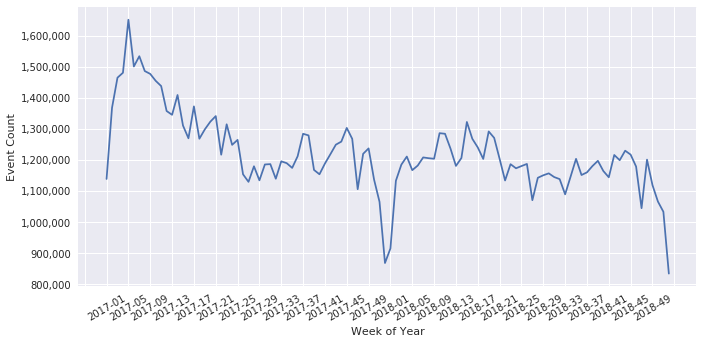

In [101]:
# group by week_year
data = counts_by_week_year(df_events)

# group by week and plot
x=data["YearWeek"]
y=data["Count"]

plot_line_over_time(x,y,"Event Count","All_Events_Counts")

### Plot trump mentions

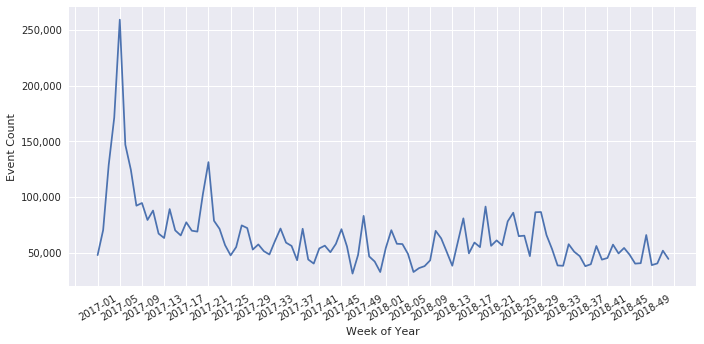

In [102]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('trump'))

# group by week_year
data = counts_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y=data["Count"]

plot_line_over_time(x,y,"Event Count","Trump_Events_Counts")

### Plot tariff mentions

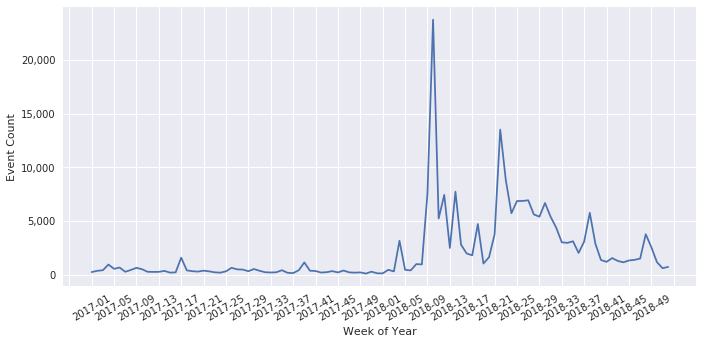

In [103]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('tariff')
                                  | df_events.SOURCEURL.rlike('trade*war'))

# group by week_year
data = counts_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y=data["Count"]

plot_line_over_time(x,y,"Event Count","Tariff_Events_Counts")

### Plot trump tone

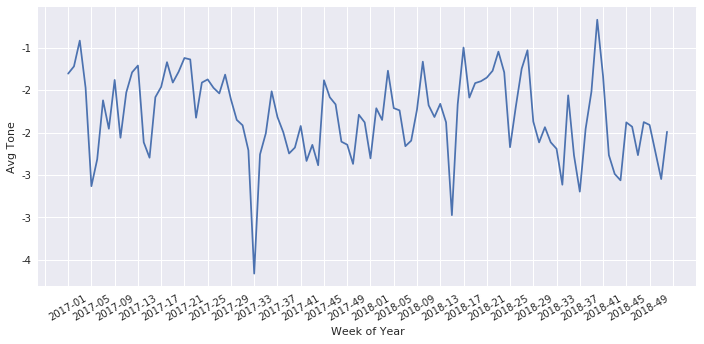

In [115]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('trump'))

# group by week_year
data = avg_tone_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y=data["AvgTone"]

plot_line_over_time(x,y,"Avg Tone","Trump_Events_Tone")

### Plot tariff tone

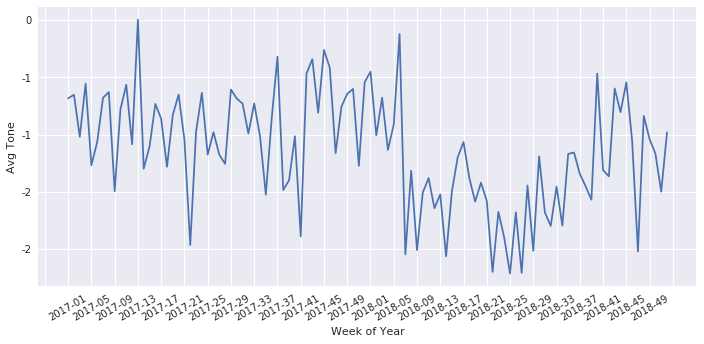

In [114]:
# get relevant events
relevant_events = df_events.where(df_events.SOURCEURL.rlike('tariff')
                                  | df_events.SOURCEURL.rlike('trade*war'))

# group by week_year
data = avg_tone_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y=data["AvgTone"]

plot_line_over_time(x,y,"Avg Tone","Tariff_Events_Tone")

In [125]:
relevant_events = df_events.where(df_events.SOURCEURL.rlike('tariff')
                                  | df_events.SOURCEURL.rlike('trade*war')) #.select(["SOURCEURL"])
relevant_events.count()
#rec = pd.DataFrame(relevant_events.take(50))
#rec.columns = colnames_events
#rec

219153

# Stop Spark Context

In [ ]:
spark.stop()